Helps to visualize the outputs of various masking approachs utilizing both ground truth segmentations as well as gaze information
 

In [20]:
import numpy as np
import matplotlib.pyplot as plt 
from dataloader import RoboGazeDataset
import argparse
from utils import load_file_markers, get_data_transforms
import pickle
import os
import random 

parser = argparse.ArgumentParser()
parser.add_argument("--actdiff_gaze_threshold", type=float, default=0, help="Value to threshold Gaze Heatmaps at")

transforms = get_data_transforms("cxr", normalization_type="train_images")
source="cxr_p"

In [21]:
with open('/media/pneumothorax/cxr_tube_dict.pkl', 'rb') as f:          
        cxr_tube_dict = pickle.load(f)

file_dir = os.path.join("./filemarkers", source)
file_markers_dir = os.path.join(file_dir, "trainval_list.pkl")
with open(file_markers_dir, "rb") as fp:
    file_markers = pickle.load(fp)

positives = [img_id for img_id, label in file_markers if label]
negatives = [img_id for img_id, label in file_markers if not label]

positive_tubes = [img_id for img_id in positives if cxr_tube_dict[img_id.split("/")[-1].split(".dcm")[0]]]
positive_no_tubes = [img_id for img_id in positives if not cxr_tube_dict[img_id.split("/")[-1].split(".dcm")[0]]]

negatives_tubes = [img_id for img_id in negatives if cxr_tube_dict[img_id.split("/")[-1].split(".dcm")[0]]]
negatives_no_tubes = [img_id for img_id in negatives if not cxr_tube_dict[img_id.split("/")[-1].split(".dcm")[0]]]


abnormality_tube_ids = random.sample(positive_tubes, 5)
abnormality_no_tube_ids = random.sample(positive_no_tubes, 5)
no_abnormality_tube_ids = random.sample(negatives_tubes, 5)
no_abnormality_no_tube_ids = random.sample(negatives_no_tubes, 5)

In [22]:
def get_indices(dataset,abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids):

    group_indices = {"abnormality_tube": [], "abnormality_no_tube": [], "no_abnormality_tube": [], "no_abnormality_no_tube": []}
    for idx, file_marker in enumerate(dataset.file_markers):
        img_id = file_marker[0]

        if img_id in abnormality_tube_ids:
            group_indices["abnormality_tube"].append(idx)

        if img_id in abnormality_no_tube_ids:
            group_indices["abnormality_no_tube"].append(idx)

        if img_id in no_abnormality_tube_ids:
            group_indices["no_abnormality_tube"].append(idx)

        if img_id in no_abnormality_no_tube_ids:
            group_indices["no_abnormality_no_tube"].append(idx)

        
    return group_indices

Ground Truth Segmentation

760 files in train split...
760 gaze sequences in train split...
191 files in val split...
191 gaze sequences in val split...


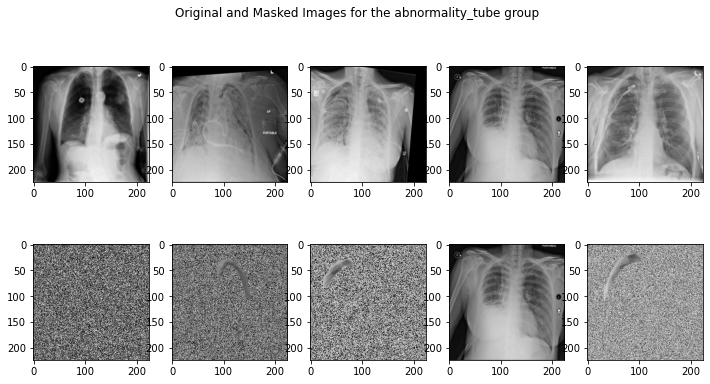

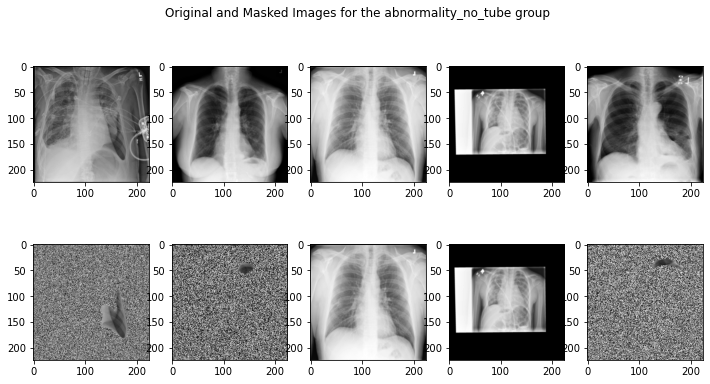

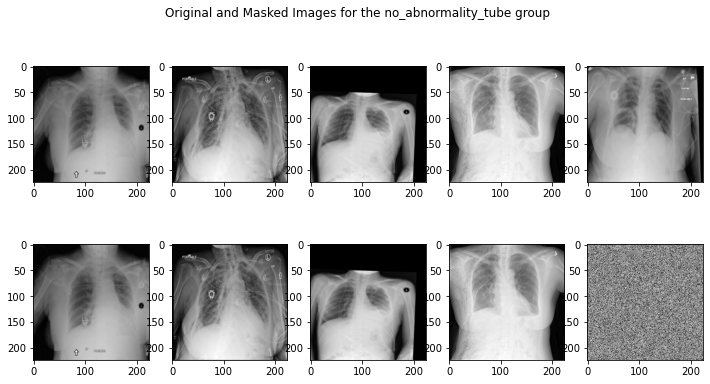

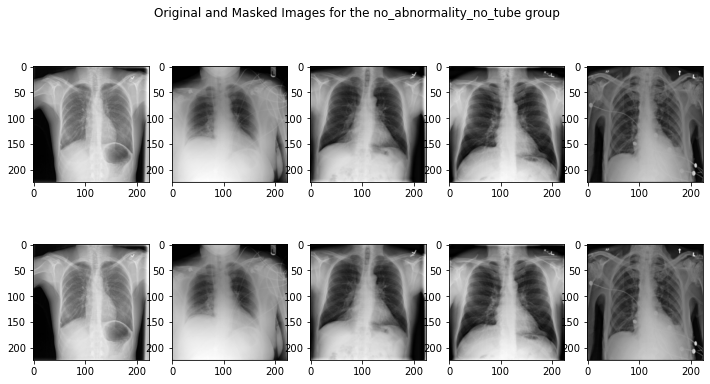

In [23]:
segmentation_datset = RoboGazeDataset(source, "/media", "train", transforms['train'], gaze_task="actdiff")
segmentation_datset_val = RoboGazeDataset(source, "/media", "val", transforms['val'], gaze_task="actdiff")

segmentation_image_indices_train = get_indices(segmentation_datset, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )
segmentation_image_indices_val = get_indices(segmentation_datset_val, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )


for key in segmentation_image_indices_train.keys():
    
    output = []
    for train_idx in segmentation_image_indices_train[key]:
        output.append(segmentation_datset.__getitem__(train_idx))

    for val_idx in segmentation_image_indices_val[key]:
        output.append(segmentation_datset_val.__getitem__(val_idx))

    fig = plt.figure(figsize=(12, 6))
    columns = 5
    rows = 2
    for i in range(1, columns + 1):
        model_output = output[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(model_output[0][0, :, :], cmap="gray")

        fig.add_subplot(rows, columns, i + 5)
        plt.imshow(model_output[2][0, :, :], cmap="gray")
    
    fig.suptitle(f"Original and Masked Images for the {key} group")


Gaze Heatmap 

760 files in train split...
760 gaze sequences in train split...
191 files in val split...
191 gaze sequences in val split...


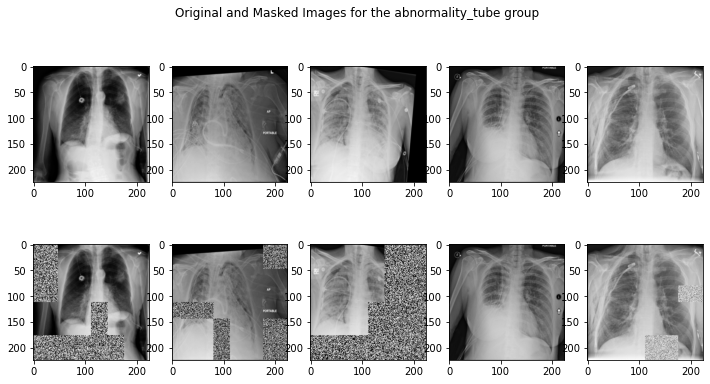

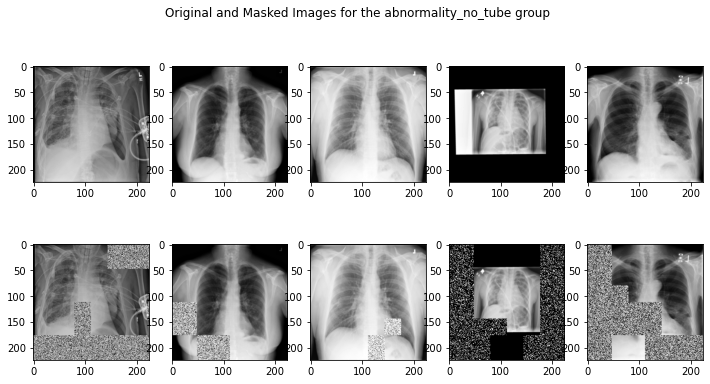

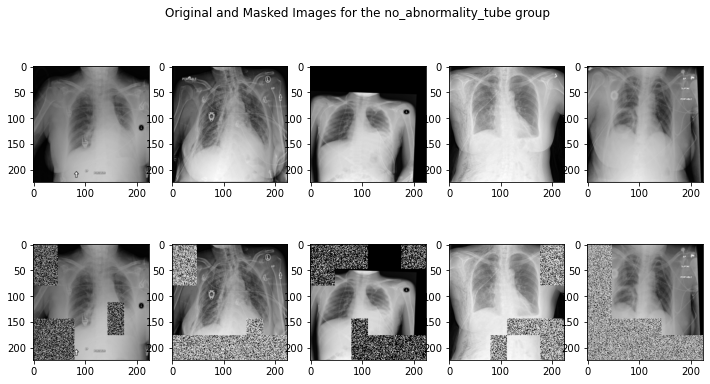

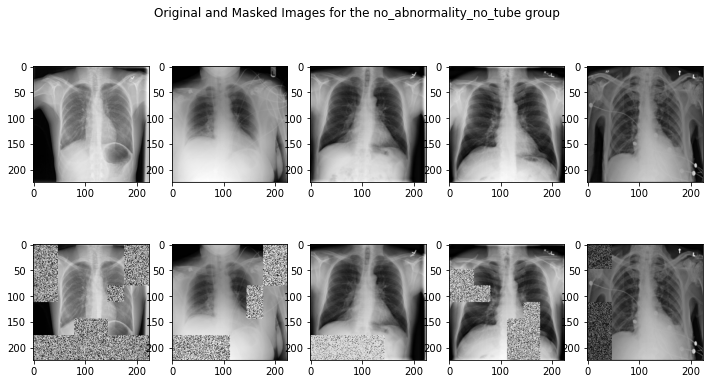

In [24]:
args = parser.parse_args(['--actdiff_gaze_threshold', '0'])
gaze_dataset = RoboGazeDataset(source, "/media", "train", transforms['train'], gaze_task="actdiff_gaze", args = args)
gaze_dataset_val = RoboGazeDataset(source, "/media", "val", transforms['val'], gaze_task="actdiff_gaze", args = args)

gaze_image_indices_train = get_indices(gaze_dataset, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )
gaze_image_indices_val = get_indices(gaze_dataset_val, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )

for key in gaze_image_indices_train.keys():
    
    output = []
    for train_idx in gaze_image_indices_train[key]:
        output.append(gaze_dataset.__getitem__(train_idx))

    for val_idx in gaze_image_indices_val[key]:
        output.append(gaze_dataset_val.__getitem__(val_idx))

    fig = plt.figure(figsize=(12, 6))
    columns = 5
    rows = 2
    for i in range(1, columns + 1):
        model_output = output[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(model_output[0][0, :, :], cmap="gray")

        fig.add_subplot(rows, columns, i + 5)
        plt.imshow(model_output[2][0, :, :], cmap="gray")
    
    fig.suptitle(f"Original and Masked Images for the {key} group")


Gaze Heatmap with a Threshold of 0.1

760 files in train split...
760 gaze sequences in train split...
191 files in val split...
191 gaze sequences in val split...


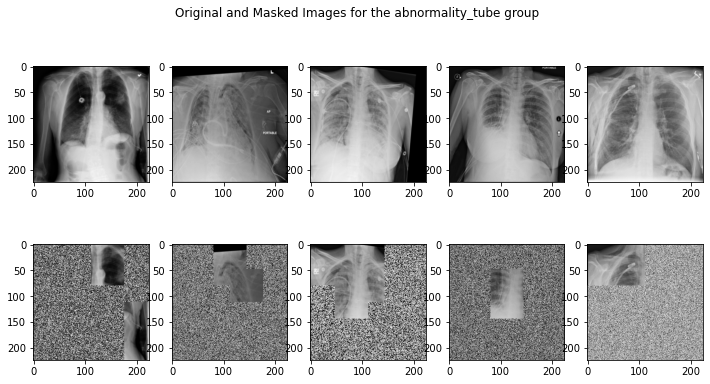

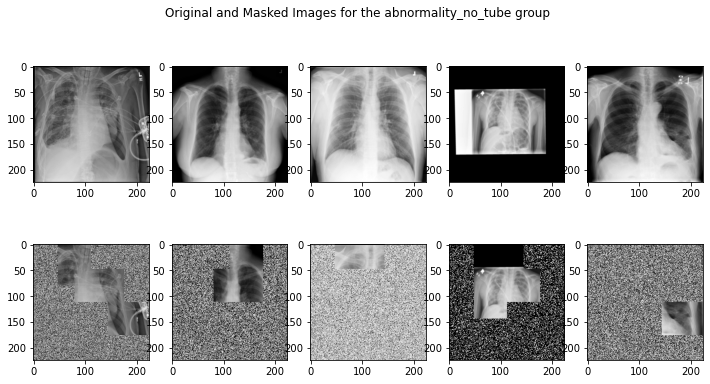

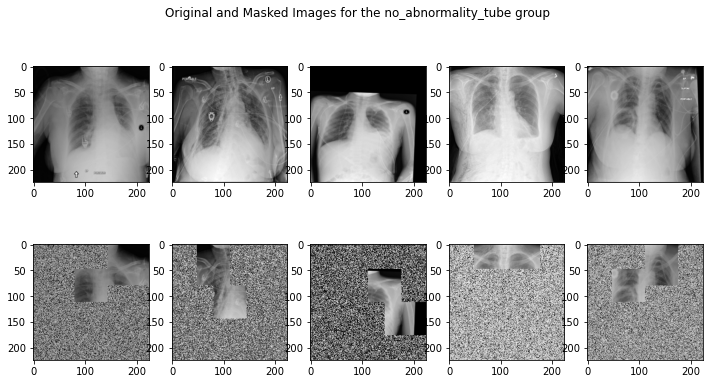

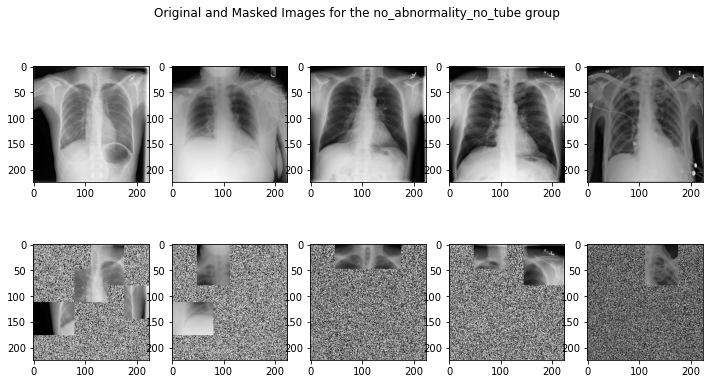

In [25]:
args = parser.parse_args(['--actdiff_gaze_threshold', '0.1'])
gaze_threshold_datset = RoboGazeDataset(source, "/media", "train", transforms['train'], gaze_task="actdiff_gaze", args = args)
gaze_threshold_datset_val = RoboGazeDataset(source, "/media", "val", transforms['val'], gaze_task="actdiff_gaze", args = args)

gaze_threshold_image_indices_train = get_indices(gaze_threshold_datset, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )
gaze_threshold_image_indices_val = get_indices(gaze_threshold_datset_val, abnormality_tube_ids, abnormality_no_tube_ids, no_abnormality_tube_ids, no_abnormality_no_tube_ids )

for key in gaze_threshold_image_indices_train.keys():
    
    output = []
    for train_idx in gaze_threshold_image_indices_train[key]:
        output.append(gaze_threshold_datset.__getitem__(train_idx))

    for val_idx in gaze_threshold_image_indices_val[key]:
        output.append(gaze_threshold_datset_val.__getitem__(val_idx))

    fig = plt.figure(figsize=(12, 6))
    columns = 5
    rows = 2
    for i in range(1, columns + 1):
        model_output = output[i - 1]
        fig.add_subplot(rows, columns, i)
        plt.imshow(model_output[0][0, :, :], cmap="gray")

        fig.add_subplot(rows, columns, i + 5)
        plt.imshow(model_output[2][0, :, :], cmap="gray")
    
    fig.suptitle(f"Original and Masked Images for the {key} group")


